#### PPGIA - Unifor - Prof. Daniel - Processamento e analise de imagens digitais - TrabalhoFinal03 - Denoising Não-Supervisionado

#### Redução de ruído de imagem com codificadores automáticos usando Deep Learning

#### Usando Deep Learning para limpar imagens ruidosas com Deep Convolutional Autoencoders

#### Importação de Bibliotecas

In [3]:
import numpy as np
import pandas as pd
import cv2 
print(cv2.__version__)
#Path Google Colab para CV2
from google.colab.patches import cv2_imshow
from google.colab import files
import dlib
from skimage import io
from PIL import Image 
%matplotlib inline
#A linha acima é necessária para mostrar gráficos Matplotlib dentro de um Notebook Jupyter
from matplotlib import pyplot as plt
#import matplotlib.pylab as plt
import sys
import ipywidgets as widgets
from IPython.display import display
import scipy
from scipy import interpolate
#import face_recognition
import pickle
import gzip

4.1.2


In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.core import Dense
from tensorflow.keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

#### Undercomplete autoencoders para ser uitlizado para redução do denoising.

O Fashion-MNIST é projetado e mantido pela Zalando, uma empresa europeia de comércio eletrônico com sede em Berlim, Alemanha. O Fashion MNIST consiste em um conjunto de treinamento de 60.000 imagens e um conjunto de teste de 10.000 imagens. Cada exemplo é uma imagem em tons de cinza 28 × 28, associada a um rótulo de 10 classes. O Fashion MNIST, que contém imagens de itens de roupas (conforme mostrado na Figura 11-5), é projetado como um conjunto de dados alternativo ao conjunto de dados MNIST, que contém dígitos manuscritos.

#### Baixando o Dataset


In [5]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
# Não precisa utilizar y_train e  y_test
(x_train, _), (x_test, _) = fashion_mnist.load_data()
print('O valor máximo no x_train é', x_train[0].max())
print('O valor mínimo no x_train é', x_train[0].min())

4431872/4422102 [==============================] - 0s 0us/step
Max value in the x_train is 255
Min value in the x_train is 0


#### Agora vamos gerar uma grade com exemplos de nosso conjunto de dados com as seguintes linhas:

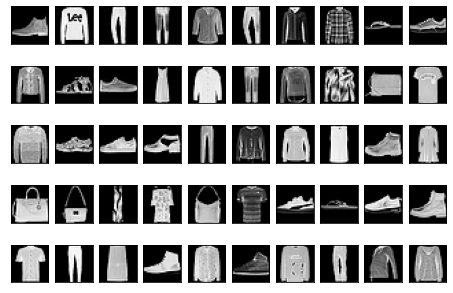

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 10) 
fig.tight_layout(pad=-1)
plt.gray()
a = 0 
for i in range(5): 
  for j in range(10): 
    axs[i, j].imshow(tf.squeeze(x_test[a])) 
    axs[i, j].xaxis.set_visible(False) 
    axs[i, j].yaxis.set_visible(False) 
    a = a + 1 

#### Processando os dados do Fashion MNIST

Para eficiência computacional e confiabilidade do modelo, temos que aplicar a normalização Minmax aos dados de nossa imagem, limitando a faixa de valores entre 0 e 1. Como nossos dados estão no formato RGB, o valor mínimo é 0 e o valor máximo é 255 e podemos conduzir a operação de normalização Minmax com as seguintes linhas:

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#### Inclusão da quarta dimensão para formatos em tons de cinza

In [11]:
x_train = x_train[..., tf.newaxis] 
x_test = x_test[..., tf.newaxis] 

#### Visualização do Shape

In [12]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


#### Inclusão de Ruído de forma randômica

In [13]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

#### Confirmando que os valores estão dentro do range

In [14]:
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.) 
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

#### Criando uma visualização das imagenes com ruído

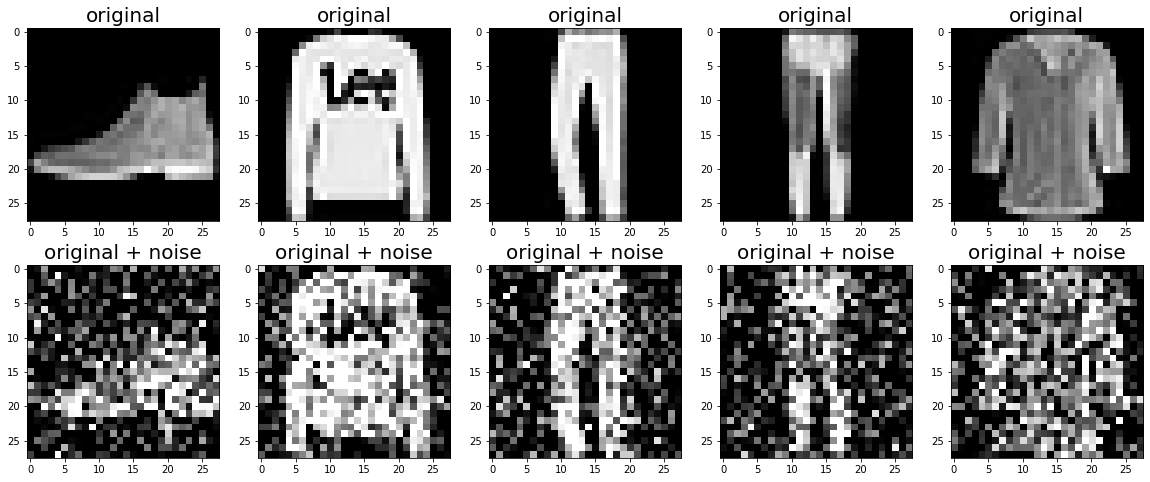

In [15]:
n = 5
plt.figure(figsize=(20, 8))
plt.gray()
for i in range(n):
  ax = plt.subplot(2, n, i + 1) 
  plt.title("original", size=20) 
  plt.imshow(tf.squeeze(x_test[i])) 
  plt.gray() 
  bx = plt.subplot(2, n, n+ i + 1) 
  plt.title("original + noise", size=20) 
  plt.imshow(tf.squeeze(x_test_noisy[i])) 
plt.show()

#### Construindo o modelo

In [16]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Input

class NoiseReducer(tf.keras.Model): 
  def __init__(self):

    super(NoiseReducer, self).__init__() 

    self.encoder = tf.keras.Sequential([ 
      Input(shape=(28, 28, 1)), 
      Conv2D(16, (3,3), activation='relu', padding='same', strides=2), 
      Conv2D(8, (3,3), activation='relu', padding='same', strides=2)]) 
    
    self.decoder = tf.keras.Sequential([ 
      Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'), 
      Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'), 
      Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')]) 
  
  def call(self, x): 
    encoded = self.encoder(x) 
    decoded = self.decoder(encoded) 
    return decoded

#### chamando o modelo para criar o objeto, depois chamar um otimização com erro quadrático

In [17]:
autoencoder = NoiseReducer()

In [18]:
autoencoder.compile(optimizer='adam', loss='mse')

Finalmente, podemos executar nosso modelo por 10 épocas, alimentando as imagens com ruído e as imagens limpas, o que levará cerca de 1 minuto para treinar. Também usamos conjuntos de dados de teste para validação. O código a seguir é para treinar o modelo#

In [19]:
autoencoder.fit(x_train_noisy, 
                x_train, 
                epochs=10, 
                shuffle=True, 
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 71s 37ms/step - loss: 0.0240 - val_loss: 0.0174
Epoch 2/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0170 - val_loss: 0.0168
Epoch 3/10
1875/1875 [==============================] - 69s 37ms/step - loss: 0.0165 - val_loss: 0.0164
Epoch 4/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0161 - val_loss: 0.0160
Epoch 5/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0157 - val_loss: 0.0156
Epoch 6/10
1875/1875 [==============================] - 69s 37ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 7/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 8/10
1875/1875 [==============================] - 69s 37ms/step - loss: 0.0151 - val_loss: 0.0151
Epoch 9/10
1875/1875 [==============================] - 69s 37ms/step - loss: 0.0150 - val_loss: 0.0149
Epoch 10/10
1875/1875 [==============================] - 69s 37m

#### Limpando as imagens com ruído

In [20]:
encoded_imgs=autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs=autoencoder.decoder(encoded_imgs)

#### Visualizando por amostragem o resultado

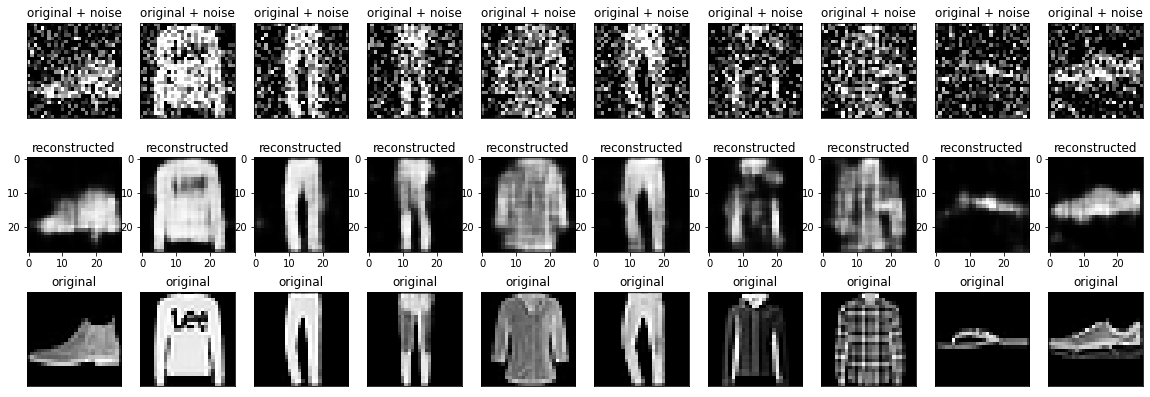

In [21]:

n = 10 
plt.figure(figsize=(20, 7))
plt.gray()
for i in range(n): 
  # display original + noise 
  bx = plt.subplot(3, n, i + 1) 
  plt.title("original + noise") 
  plt.imshow(tf.squeeze(x_test_noisy[i])) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 
  
  # display reconstruction 
  cx = plt.subplot(3, n, i + n + 1) 
  plt.title("reconstructed") 
  plt.imshow(tf.squeeze(decoded_imgs[i])) 
  bx.get_xaxis().set_visible(False) 
  bx.get_yaxis().set_visible(False) 
  
  # display original 
  ax = plt.subplot(3, n, i + 2*n + 1) 
  plt.title("original") 
  plt.imshow(tf.squeeze(x_test[i])) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 

plt.show()